# Week 1 : Basic of NLP

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

Load the dataset

In [12]:
data = pd.read_csv('movie.csv')

Check Data

In [13]:
print(data.head())
print(data.info())
print(data.describe())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
              label
count  40000.000000
mean       0.499525
std        0.500006
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


Check for Duplicates and remove them

In [14]:
duplicates = data.duplicated().sum()
print(f'Duplicate entries: {duplicates}')
data = data.drop_duplicates()

Duplicate entries: 277


Check for missing values

In [15]:
missing = data.isnull().sum()
print(f'Missing values:\n{missing}')


Missing values:
text     0
label    0
dtype: int64


Check for inconsistent data

In [16]:
print(data['label'].value_counts())

label
1    19908
0    19815
Name: count, dtype: int64


Visualize the distribution of sentiments label vs data

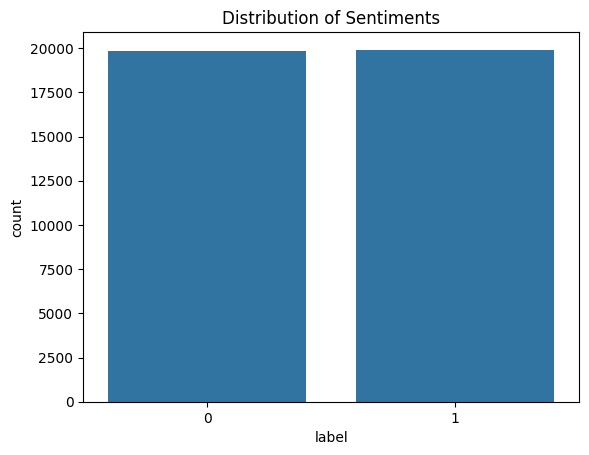

In [17]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Sentiments')
plt.show()

Visualize review length vs sentiment

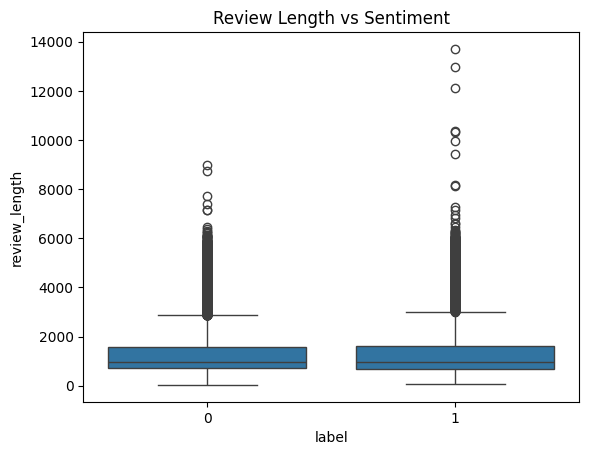

In [18]:
data['review_length'] = data['text'].apply(len)
sns.boxplot(x='label', y='review_length', data=data)
plt.title('Review Length vs Sentiment')
plt.show()

## Data Pre Processing

Removing Stopwords, emojis, hashtags and convert into lowercase, removing puntuations and stemming and lemmatisation

In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'\s+[a-z]\s+', ' ', text)
    text = re.sub(r'\^[a-z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming and Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

data['cleaned_review'] = data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Perform train/test split

In [20]:
X = data['cleaned_review']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Extraction

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

One Hot Encoding

In [22]:
vectorizer = CountVectorizer(binary=True)
X_train_one_hot = vectorizer.fit_transform(X_train)
X_test_one_hot = vectorizer.transform(X_test)

Bag of Words

In [23]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

Count Vectorizer

In [24]:
vectorizer = CountVectorizer(max_features=5000)
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

TF-IDF Vectorizer

In [25]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Word2Vec

In [ ]:
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
X_train_word2vec = [word2vec_model.wv[text] for text in X_train_tokens]
X_test_word2vec = [word2vec_model.wv[text] for text in X_test_tokens]

## Model Selection

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import tensorflow as tf

Logistic Regression

In [27]:
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tfidf)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_tfidf)[:, 1]

Bernoulli Naive Bayes

In [28]:
bnb = BernoulliNB()
bnb.fit(X_train_tfidf, y_train)
y_pred_bnb = bnb.predict(X_test_tfidf)
y_pred_proba_bnb = bnb.predict_proba(X_test_tfidf)[:, 1]

SVM

In [37]:
svm = SVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
y_pred_proba_svm = svm.predict_proba(X_test_tfidf)[:, 1]

Random Forests

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
y_pred_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1]

Simple Neural Network

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_tfidf.toarray(), y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_nn = (model.predict(X_test_tfidf.toarray()) > 0.5).astype("int32")
y_pred_proba_nn = model.predict(X_test_tfidf.toarray())

c:\Users\vaibh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8158 - loss: 0.3926 - val_accuracy: 0.8774 - val_loss: 0.2883
Epoch 2/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9275 - loss: 0.1839 - val_accuracy: 0.8768 - val_loss: 0.3082
Epoch 3/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9755 - loss: 0.0706 - val_accuracy: 0.8650 - val_loss: 0.4575
Epoch 4/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9975 - loss: 0.0097 - val_accuracy: 0.8704 - val_loss: 0.7230
Epoch 5/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 1.0000 - loss: 7.1917e-04 - val_accuracy: 0.8715 - val_loss: 0.8460
Epoch 6/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 1.0000 - loss: 1.1529e-04 - val_accuracy: 0.8710 - val_loss: 0.9395
Epoch 7/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 1.0000 - loss: 4.2203e-05 - val_accuracy: 0.8718 - val_loss: 1.0101
Epoch 8/10
795/795 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 1.0000 - los

## Evaluation

Give Accuracy, ROC-AUC, F1 Score, Confusion Matrix and Plot ROC Curve and Precesion-Recall Curve

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def evaluate_model(y_test, y_pred, y_pred_proba, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'{model_name} - Accuracy: {accuracy}')
    print(f'{model_name} - ROC-AUC: {roc_auc}')
    print(f'{model_name} - F1 Score: {f1}')
    print(f'{model_name} - Confusion Matrix:\n{cm}')
    
    # # Plot Confusion Matrix
    # plot_confusion_matrix(model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'], cmap=plt.cm.Blues)
    # plt.title(f'{model_name} - Confusion Matrix')
    # plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall curve')
    plt.show()

Logistic Regression

Logistic Regression - Accuracy: 0.8818124606670862
Logistic Regression - ROC-AUC: 0.953232976016979
Logistic Regression - F1 Score: 0.8827568984891997
Logistic Regression - Confusion Matrix:
[[3471  520]
 [ 419 3535]]


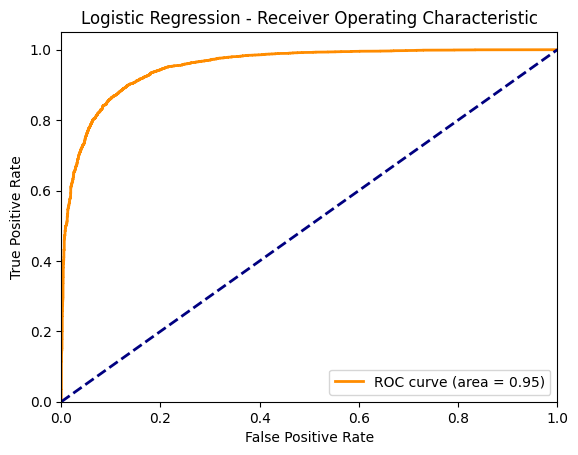

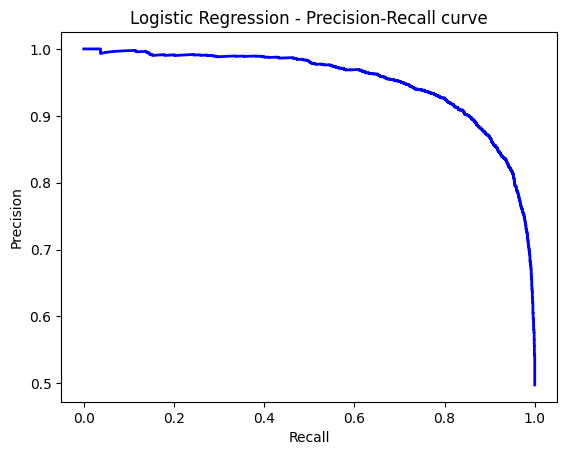

In [32]:
evaluate_model(y_test, y_pred_log_reg, y_pred_proba_log_reg, "Logistic Regression")

Bernoulli Naive Bayes

Bernoulli Naive Bayes - Accuracy: 0.8426683448709881
Bernoulli Naive Bayes - ROC-AUC: 0.9165046620449881
Bernoulli Naive Bayes - F1 Score: 0.8408454290807232
Bernoulli Naive Bayes - Confusion Matrix:
[[3393  598]
 [ 652 3302]]


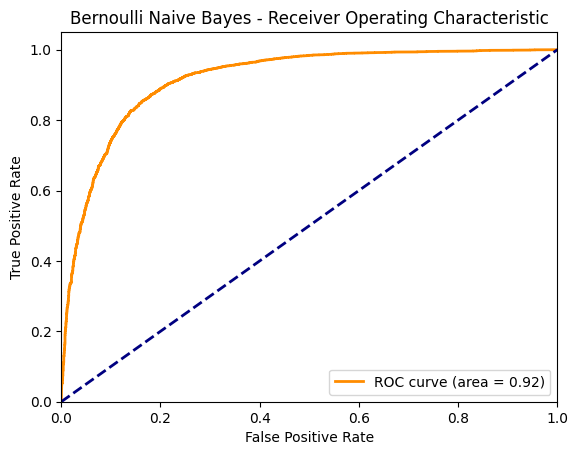

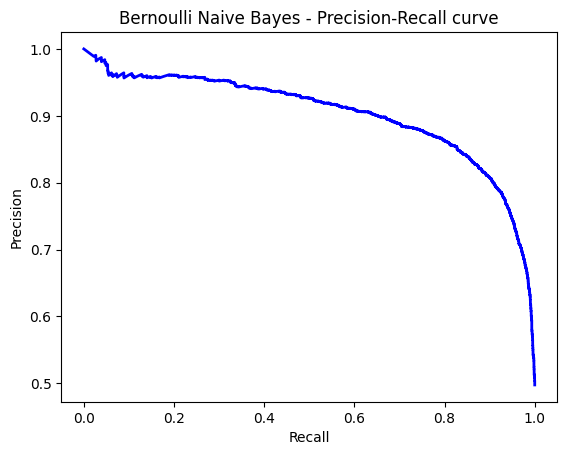

In [33]:
evaluate_model(y_test, y_pred_bnb, y_pred_proba_bnb, "Bernoulli Naive Bayes")

SVM

In [ ]:
evaluate_model(y_test, y_pred_svm, y_pred_proba_svm, "SVM")

Random Forests

Random Forests - Accuracy: 0.84745122718691
Random Forests - ROC-AUC: 0.9247352129037932
Random Forests - F1 Score: 0.845131612573473
Random Forests - Confusion Matrix:
[[3426  565]
 [ 647 3307]]


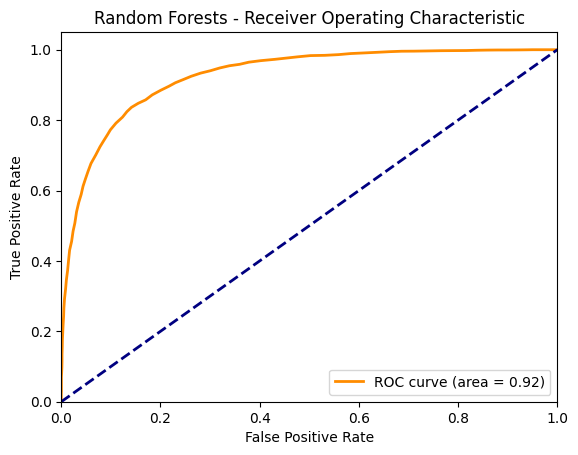

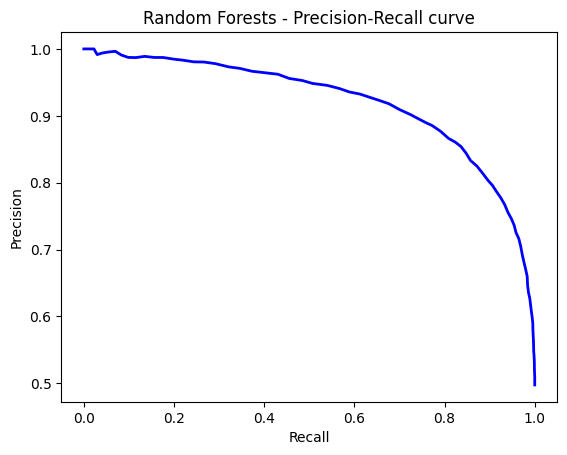

In [34]:
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forests")

Simple Neural Network

Neural Network - Accuracy: 0.8665827564505979
Neural Network - ROC-AUC: 0.9373258521607861
Neural Network - F1 Score: 0.8665323596071518
Neural Network - Confusion Matrix:
[[3444  547]
 [ 513 3441]]


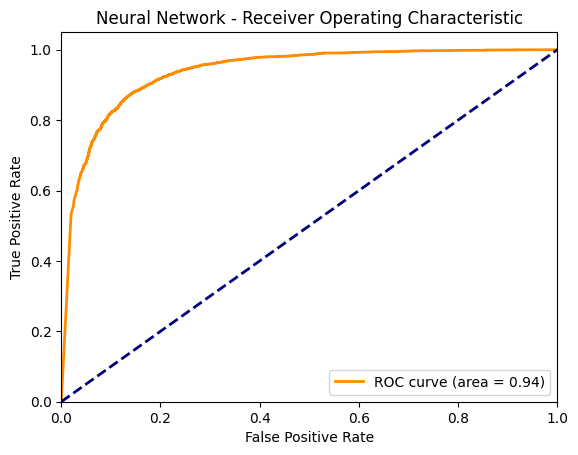

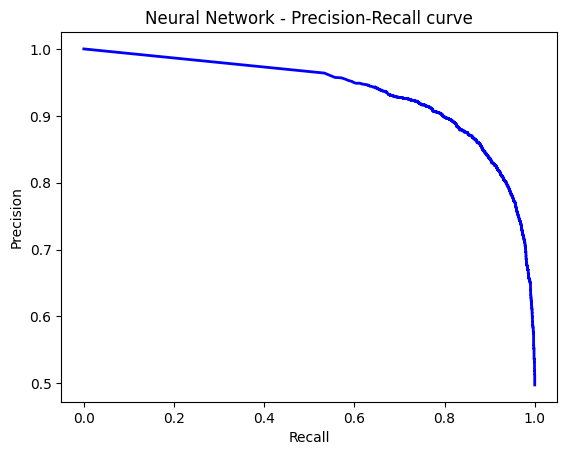

In [35]:
evaluate_model(y_test, y_pred_nn, y_pred_proba_nn, "Neural Network")